# Image Captioning - Model Training

In this notebook, we will train the image captioning model using the pre-extracted features from the CNN encoder. We will:

1. Set up the data loaders for training and validation
2. Build the caption model (combining the encoder and decoder)
3. Define the training pipeline with teacher forcing
4. Train the model with appropriate hyperparameters
5. Monitor the training progress and validation performance
6. Save the trained model for later evaluation

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import time
import h5py

# Add project root to path
sys.path.append('..')

# Import project modules
from models.encoder import EncoderCNN
from models.decoder import DecoderRNN
from models.caption_model import CaptionModel
sys.path.append('/content/models')

from utils.vocabulary import Vocabulary
from utils.dataset import get_data_loaders
from utils.trainer import CaptionTrainer
sys.path.append('/content/utils')

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## 1. Configuration Settings

In [ ]:
# Define configuration settings
config = {
    # Data settings
    'data_dir': '../content/data/flickr8k/',
    'batch_size': 64,
    'num_workers': 2,

    # Model settings
    'encoder_model': 'resnet18',  # Options: 'resnet18', 'resnet50', 'mobilenet_v2'
    'embed_size': 256,
    'hidden_size': 512,
    'num_layers': 1,
    'dropout': 0.5,
    'decoder_type': 'lstm',  # Options: 'lstm', 'gru'

    # Training settings
    'learning_rate': 3e-4,
    'num_epochs': 10,  # Increase for better results
    'early_stopping_patience': 5,
    'save_dir': '../models',

    # Device settings
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Create save directory if it doesn't exist
os.makedirs(config['save_dir'], exist_ok=True)

# Print configuration
for section, items in {
    'Data': ['data_dir', 'batch_size', 'num_workers'],
    'Model': ['encoder_model', 'embed_size', 'hidden_size', 'num_layers', 'dropout', 'decoder_type'],
    'Training': ['learning_rate', 'num_epochs', 'early_stopping_patience', 'save_dir'],
    'Device': ['device']
}.items():
    print(f"\n{section} settings:")
    for item in items:
        print(f"  {item}: {config[item]}")


Data settings:
  data_dir: ../content/data/flickr8k/
  batch_size: 64
  num_workers: 2

Model settings:
  encoder_model: resnet18
  embed_size: 256
  hidden_size: 512
  num_layers: 1
  dropout: 0.5
  decoder_type: lstm

Training settings:
  learning_rate: 0.0003
  num_epochs: 10
  early_stopping_patience: 5
  save_dir: ../models

Device settings:
  device: cuda


## 2. Load Data

In [ ]:
# Get data loaders
train_loader, val_loader, test_loader, vocab = get_data_loaders(
    data_dir=config['data_dir'],
    batch_size=config['batch_size'],
    num_workers=config['num_workers']
)

# Update vocabulary size in config
config['vocab_size'] = len(vocab)
print(f"Vocabulary size: {config['vocab_size']}")

# Display data loader information
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Vocabulary size: 2986
Training batches: 468
Validation batches: 79
Test batches: 5000


## 3. Create Model

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
# Create caption model
model = CaptionModel(
    embed_size=config['embed_size'],
    hidden_size=config['hidden_size'],
    vocab_size=config['vocab_size'],
    num_layers=config['num_layers'],
    encoder_model=config['encoder_model'],
    decoder_type=config['decoder_type'],
    dropout=config['dropout'],
    train_encoder=False  # Don't train the encoder (use pre-trained weights)
)

# Print model architecture
# print(model)
summary(model, input_size=[(1, 3, 128, 128), (1, 20)], dtypes=[torch.float, torch.long])

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Layer (type:depth-idx)                             Output Shape              Param #
CaptionModel                                       [1, 19, 2986]             --
├─EncoderCNN: 1-1                                  [1, 256]                  --
│    └─ResNet: 2-1                                 [1, 512]                  --
│    │    └─Conv2d: 3-1                            [1, 64, 64, 64]           (9,408)
│    │    └─BatchNorm2d: 3-2                       [1, 64, 64, 64]           (128)
│    │    └─ReLU: 3-3                              [1, 64, 64, 64]           --
│    │    └─MaxPool2d: 3-4                         [1, 64, 32, 32]           --
│    │    └─Sequential: 3-5                        [1, 64, 32, 32]           (147,968)
│    │    └─Sequential: 3-6                        [1, 128, 16, 16]          (525,568)
│    │    └─Sequential: 3-7                        [1, 256, 8, 8]            (2,099,712)
│    │    └─Sequential: 3-8                        [1, 512, 4, 4]            (8,393,

In [ ]:
# Calculate model size
def count_parameters(model: nn.Module):
    """Count the number of trainable parameters in a model."""
    num_of_trainable_parameters = sum([param.numel() for param in model.parameters() if param.requires_grad])
    return num_of_trainable_parameters

# Calculate and print model size
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")

# Calculate encoder and decoder sizes separately
encoder_params = count_parameters(model.encoder)
decoder_params = count_parameters(model.decoder)
print(f"Encoder parameters: {encoder_params:,} ({encoder_params / num_params * 100:.1f}%)")
print(f"Decoder parameters: {decoder_params:,} ({decoder_params / num_params * 100:.1f}%)")

Number of trainable parameters: 4136618
Encoder parameters: 131,840 (3.2%)
Decoder parameters: 4,004,778 (96.8%)


## 4. Train the Model

In [ ]:
# Create trainer
trainer = CaptionTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocab=vocab,
    device=config['device'],
    learning_rate=config['learning_rate'],
    model_save_dir=config['save_dir']
)

In [ ]:
# Train the model
history = trainer.train(
    epochs=config['num_epochs'],
    early_stopping_patience=config['early_stopping_patience'],
    evaluate_every=1,
    generate_every=5  # Generate captions and calculate BLEU every 5 epochs
)

Starting training for 10 epochs...
Training on device: cuda


Epoch 1:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 4.8715


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 4.2212
Model checkpoint saved to ../models/best_model_loss.pth
Epoch 1/10 completed in 224.75s - Train Loss: 4.8715, Val Loss: 4.2212


Epoch 2:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 4.0245


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 - Val Loss: 3.8475
Model checkpoint saved to ../models/best_model_loss.pth
Epoch 2/10 completed in 215.41s - Train Loss: 4.0245, Val Loss: 3.8475


Epoch 3:   0%|          | 0/468 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive():
            ^  ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3

Epoch 3 - Train Loss: 3.7189


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive(): 
      ^^^^^ ^ ^ ^ ^^^^
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^  ^ ^   ^ ^Exception igno

Epoch 3 - Val Loss: 3.6505
Model checkpoint saved to ../models/best_model_loss.pth
Epoch 3/10 completed in 218.13s - Train Loss: 3.7189, Val Loss: 3.6505


Epoch 4:   0%|          | 0/468 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
       ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python

Epoch 4 - Train Loss: 3.5279


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():
        ^^ ^ ^ ^^ ^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^Exception ignored in: 
^<func

Epoch 4 - Val Loss: 3.5270
Model checkpoint saved to ../models/best_model_loss.pth
Epoch 4/10 completed in 218.03s - Train Loss: 3.5279, Val Loss: 3.5270


Epoch 5:   0%|          | 0/468 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers()^^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^^
^ ^^ ^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^^  ^^  ^^ ^ ^ ^ ^ ^ 
^  File "/us

Epoch 5 - Train Loss: 3.3905


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in:        <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in:   if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive():  
        ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> ^ 
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    

Traceback (most recent call last):
if w.is_alive():Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
    
Exception ignored in: self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datalo

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()
   
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
^ ^ ^  ^ ^ ^ ^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
^^Traceback (most recent call last):
^^Exception ignored in:   File "/usr/local/lib/python3.11/dist-pa

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
     ^ ^ ^^^Exception ignored in:  Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^ ^

^Traceback (mos

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive(): Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  
^Exception ignored in:  
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call l

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

           ^ ^ ^ ^^^Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most r

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():    
self._shutdown_workers() 
  Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>   
^
^Exception ignored in: ^^Traceback (most recent call last):
^^^   File "/usr/local/lib/python3.11/dist-packages/torch/ut

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
      ^   ^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datalo

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():
 
Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  
 Exception ignored in:  Traceback (most recent call last):
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/d

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
       ^^^^if w.is_alive():^
 ^ ^ ^^^^ ^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'
   Exception ignored in: <function _Mu

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    if w.is_alive():

          Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> ^ 
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
     Exception ignored in:    ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^ Exception ignored in: ^
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

self._shutdown_workers()    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__


  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
   

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
          ^ ^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

    Exception ignored in:   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive():  
        ^^Exception ignored in:  ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^ ^ 
^^Traceback (most recent call last):
^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dat

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
 
  Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  
          Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^ 
^^Traceback (most recent call last):
^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataload

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
         ^ ^ ^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive(): 
           Exception ignored in:   ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
           ^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
^^Exception ignored in: Traceback (most recent call last):
^^^<function _MultiProcessingDataLoaderIter.

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

       if w.is_alive(): 
        Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
Traceback (most recent call last):
^   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():
     self._shutdown_workers()   
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): ^^
 ^  ^Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^ 
^ Traceback (most recent call last):
^   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datalo

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
   Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> 
 Traceback (most recent call last):
Exception ignored in:    File "/usr/local/lib/python3.11/dist-packages/torch/utils/d

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():

 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
    ^^^^^^^^ ^^ ^ ^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process' 
         ^  ^^  ^^^^^^^^^^^^^^^
^  Fil

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      if w.is_alive(): 
       ^ ^^ ^Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> ^^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datalo

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

            ^^  ^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
Exception ignored in

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
      ^ ^^ ^ ^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/da

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
     Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
  Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", l

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
          ^Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^Exception ignored in:  
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^Traceback (most recen

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
     ^  ^ ^ Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datal

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    if w.is_alive():

 Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
     File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 161

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  
 Traceback (most recent call last):
   ^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py"

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():    
if 

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive(): 
    ^ ^^^^^^ ^^ ^ ^^ Exception ignored in: 
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^
^Exception ignored i

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    if w.is_alive():
   
   if w.is_alive():
Traceback (most recent call last):
    ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", l

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
  ^  ^Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
         Exception ignored in: if w.is_alive(): <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
  
 ^Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", 

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
     if w.is_alive(): 
Exception ignored in:  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  

  Traceback (most recent call la

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

            ^ ^ ^^^^^^^^^^^^^Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^Tracebac

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive(): 
         ^ ^ ^ ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^^Traceback (most recent call last):
^^Exception ignored in:   File "/usr/local/lib/python3.11/dist-package

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    if w.is_alive():
 
          ^ ^ ^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^^Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloa

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():

 Exception ignored in:       <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
      ^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():

             ^ ^^^^^^^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/da

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive():  
   ^^ ^^ ^^ Exception ignored in: ^ Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^^ 

   File "/usr

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    
 self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        i

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  if w.is_alive(): <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

  Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/da

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive():
        Exception ignored in: ^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^Traceback (most recent c

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
     if w.is_alive():
            ^^ ^^^^^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
Traceback (most recent call last):

^  File "/usr/lib/python3.11/multiprocessing/process.py"

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():
 
             ^^^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/da

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive():
           ^ ^ ^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloa

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
    if w.is_alive(): 
       Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    
 ^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.p

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

           Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", 

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

       if w.is_alive(): 
    ^ ^ ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^ 
 Traceback (most recent call last):
^   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataload

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

           ^ ^ Exception ignored in: ^ ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datal

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             ^ ^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
^^
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive(): 
            Exception ignored in: ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^Exception ignored in: ^
^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^Traceback (most r

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in: 
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>if w.is_alive():

Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
          ^ ^ ^^^^^^^Exception ignored in: ^^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^^^

^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
         ^ ^ ^^^ ^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
^^Traceback (most recent call last):
^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
  self._shutdown_workers() 
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():^^
^ ^^ ^ ^  ^  ^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^^Traceback (m

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
           ^ ^^^^^^^^^^^^^^^^^^^^
Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    
^^assert

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloa

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^Exception ignored in: ^^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/da

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
if w.is_alive(): 
Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>if w.is_alive():
     
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^^^if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
 ^^

   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
         ^^^^ ^^^ Exception ignored in: ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^ ^
^Traceback (most recent call last):
^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive():
           Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataload

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  
  Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", l

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     ^if w.is_alive():^
 ^ ^ ^ ^^ ^ ^ ^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback 

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():    
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive(): 
       Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> ^^^
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py"

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive(): 
           ^ ^ ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^^
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datalo

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
    if w.is_alive(): 
        Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> 
 Traceback (most recent call last):
^ ^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.

Epoch 5 - Val Loss: 3.4460, BLEU-4: 0.0424
Model checkpoint saved to ../models/best_model_loss.pth
Model checkpoint saved to ../models/best_model_bleu.pth
Epoch 5/10 completed in 4217.22s - Train Loss: 3.3905, Val Loss: 3.4460, BLEU-4: 0.0424


Epoch 6:   0%|          | 0/468 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
          if w.is_alive(): ^^
 ^^  ^ ^^ ^ ^ ^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ 
  File "/usr/lib/pytho

Epoch 6 - Train Loss: 3.2869


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    Exception ignored in:  if w.is_alive(): <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
 
  Traceback (most recent call last):
        File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", l

Epoch 6 - Val Loss: 3.3854
Model checkpoint saved to ../models/best_model_loss.pth
Epoch 6/10 completed in 361.62s - Train Loss: 3.2869, Val Loss: 3.3854


Epoch 7:   0%|          | 0/468 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive():   
   ^  ^ ^^ ^ ^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ 
   File "/usr/lib/pyt

Epoch 7 - Train Loss: 3.1978


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    Exception ignored in: if w.is_alive():
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()Exception ignored in: ^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^

^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^Traceback (m

Epoch 7 - Val Loss: 3.3413
Model checkpoint saved to ../models/best_model_loss.pth
Epoch 7/10 completed in 315.13s - Train Loss: 3.1978, Val Loss: 3.3413


Epoch 8:   0%|          | 0/468 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 
             ^^^^^^^^^^^^^^^^^^^^^^^
^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._par

Epoch 8 - Train Loss: 3.1228


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in: 
    if w.is_alive():
  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>   
  Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line

Epoch 8 - Val Loss: 3.3135
Model checkpoint saved to ../models/best_model_loss.pth
Epoch 8/10 completed in 360.67s - Train Loss: 3.1228, Val Loss: 3.3135


Epoch 9:   0%|          | 0/468 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
        ^ ^  ^^ ^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'
 ^ ^ ^ 
   File "/usr/lib/p

Epoch 9 - Train Loss: 3.0570


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 - Val Loss: 3.2780
Model checkpoint saved to ../models/best_model_loss.pth
Epoch 9/10 completed in 316.09s - Train Loss: 3.0570, Val Loss: 3.2780


Epoch 10:   0%|          | 0/468 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> 
      ^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^^^^^^^    self._shutdown_workers()^
^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
            File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive(): 
 ^      ^^^^^^^^^^^^^
  File "/u

Epoch 10 - Train Loss: 3.0003


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

     Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> ^^ 
^ Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.p

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

            ^Exception ignored in:  ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloa

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
      if w.is_alive(): 
      ^ ^ ^   ^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dat

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive():
            Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^  ^^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
 if w.is_alive():Exception ignored in: 
   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  
         Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> ^^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloade

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()  
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
 ^    if w.is_alive():^
Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
 Traceback (most recent call last):
^   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py",

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^Exception ignored in: ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^
^Trac

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

           ^^^^^ ^ ^ ^^^^^^^^^^^^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

            ^^ ^^^^ ^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    ^^^^^^assert self._parent_pid == os.getpid(), 'can only test a child process'^^^^

  File "/usr/lib/python

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
          ^^   ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datalo

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive():
         ^   ^^ ^ ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^^^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive(): 
      ^ ^ Exception ignored in: ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^ 
^^^^^^Traceback (most recent call last):
^Exception ignored in: ^^^^^  File "/usr/local/lib/python3.11/dist-pa

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
^ ^ ^ ^ ^ ^^ ^ ^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: ^    assert self._parent_pid == os.getpid(), 'can only test a child process'<functio

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^

<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/u

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():    
self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
     ^ ^^^^ ^ Exception ignored in: ^^ Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^^
  File "/us

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloa

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
if w.is_alive():       
^^^^ ^^ ^ ^ Exception ignored in: ^ ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  ^^^
^^Traceback (most recent call last):
^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/da

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
 self._shutdown_workers()  
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
  ^^^  ^  ^ ^Exception ignored in:  ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
^^^Traceback (most recent call last):
^Exception ignored in: <function _MultiProcessingDataLoaderIter.__de

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
if w.is_alive():
              ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
^      ^^
    File "/usr/li

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
      if w.is_alive(): 
      Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  
^ Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    if w.is_alive():

           ^ ^ ^^Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
^^^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/da

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    
Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():    self._shutdown_workers()
 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():
        ^  ^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
^^^Traceback (most recent call last):
^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/uti

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^Exception ignored in: 
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
^^      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()Exception ignored in: self._shutdown_workers()^^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbca

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive():^
^ ^^^ ^ ^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'
       ^ ^  ^ ^Exception ignored in: <f

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
 if w.is_alive():  
     ^^^^ Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py"

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     self._shutdown_workers()  
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive():Exception ignored in: ^
^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", l

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    if w.is_alive():

           ^ ^ ^^ Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dat

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    self._shutdown_workers()
Exception ignored in: 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    
if w.is_alive():  
Traceback (most recent call last):
     File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
           <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in:   ^^^^^^^^^^^
^^Traceback (most recent call last):
^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 16

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive(): 
       ^    ^ ^ ^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^^Traceback (most recent call last):
^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/d

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
       if w.is_alive(): 
      ^^^  ^ ^^^ ^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^Traceback (mos

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive():   
        ^  ^ ^^^^^^^^^^^^^^^Exception ignored in: ^^^^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

^Traceback (m

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():
    
      ^   ^ ^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^Traceback (most recent call last):

^  File "/usr/lib/python3.11/multiprocessing/process.py

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
            Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> ^
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.p

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():
self._shutdown_workers()
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     ^^^^^^^    ^if w.is_alive():
^^ ^    ^
  ^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^^^^^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
  ^  ^Exception ignored in:

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive():
         Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> ^ 
^^Traceback (most recent call last):
^Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
 if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
      ^ ^ ^ ^ ^ ^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive():  
   ^^  ^ ^  ^^^^^^^^^Exception ignored in: ^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
^Traceback (most recent call last):

^Exception ignored in:   File "/usr/lib/python3.11/multipr

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> 
  Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", lin

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive(): 
    Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
  Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", l

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
           Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> ^^
^Traceback (most recent call last):
^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloa

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
if w.is_alive(): 
            ^ ^^^^^^^^^^^^Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/d

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

     self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
        Exception ignored in: ^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^^^^^^^^^^^Traceback (most recent call last):
^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", li

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive():
           ^Exception ignored in: ^^ ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^ 
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datalo

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

            ^ ^ ^^^^^^^^^^^^^^^^Exception ignored in: ^^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    assert 

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():
  self._shutdown_workers() 
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():Exception ignored in: ^^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
 ^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py"

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
       Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^Traceback (most recent call last):
^   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
if w.is_alive(): 
             ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
Traceback (most recent call last):
^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datalo

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
     ^ ^ ^ ^^ ^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
^^Traceback (most recent call last):
^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

         if w.is_alive():
 Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: 

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/u

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
          ^^ ^ ^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive():
          ^^  Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
^ ^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloade

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    
self._shutdown_workers() 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
       ^ ^ ^ ^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: ^^
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (mo

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
   
    ^^^^^^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^if w.is_alive():^
^ ^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
   ^ ^ ^ ^ ^ ^ ^^ ^ ^ ^^^^^
  File "/

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
 if w.is_alive():
       Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", l

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>if w.is_alive():^


Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloa

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive():  
         ^ ^^^ ^^^^^Exception ignored in: ^Exception ignored in: ^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbca

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
 if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> 
    Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      if w.is_alive():  
         ^ ^^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: ^^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
^
Traceba

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

           ^^  ^^ ^^^^^^^^^^^^^^^^^^
^Exception ignored in:   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>    
asse

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
if w.is_alive(): 
         ^  ^ ^^^ ^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'^<functio

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in:      <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> if w.is_alive():
 
 Traceback (most recent call last):
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
 if w.is_alive(): 
          ^^^ ^ ^^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/d

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
           ^ ^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dat

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    if w.is_alive():
  
       Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> 
^^Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.p

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     self._shutdown_workers()
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
         ^^^ ^  ^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
Exception ignored in:  ^<

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
 if w.is_alive():
      Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  
  Traceback (most recent call last):
^   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

     self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive(): 
   Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> ^^^   
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloade

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

       Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0> 
  ^Traceback (most recent call last):
 ^ ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():   ^^
^^^^^  ^^ ^^^
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
   ^<function _

Generating captions:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    if w.is_alive():
     self._shutdown_workers()  
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
         ^ ^ ^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcac6efba0>^
Traceback (most recent call last):
^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils

Epoch 10 - Val Loss: 3.2542, BLEU-4: 0.0207
Model checkpoint saved to ../models/best_model_loss.pth
Epoch 10/10 completed in 4837.04s - Train Loss: 3.0003, Val Loss: 3.2542, BLEU-4: 0.0207
Model checkpoint saved to ../models/final_model.pth
Training completed!
Best validation loss: 3.2542
Best BLEU-4 score: 0.0424


## 5. Analyze Training Results

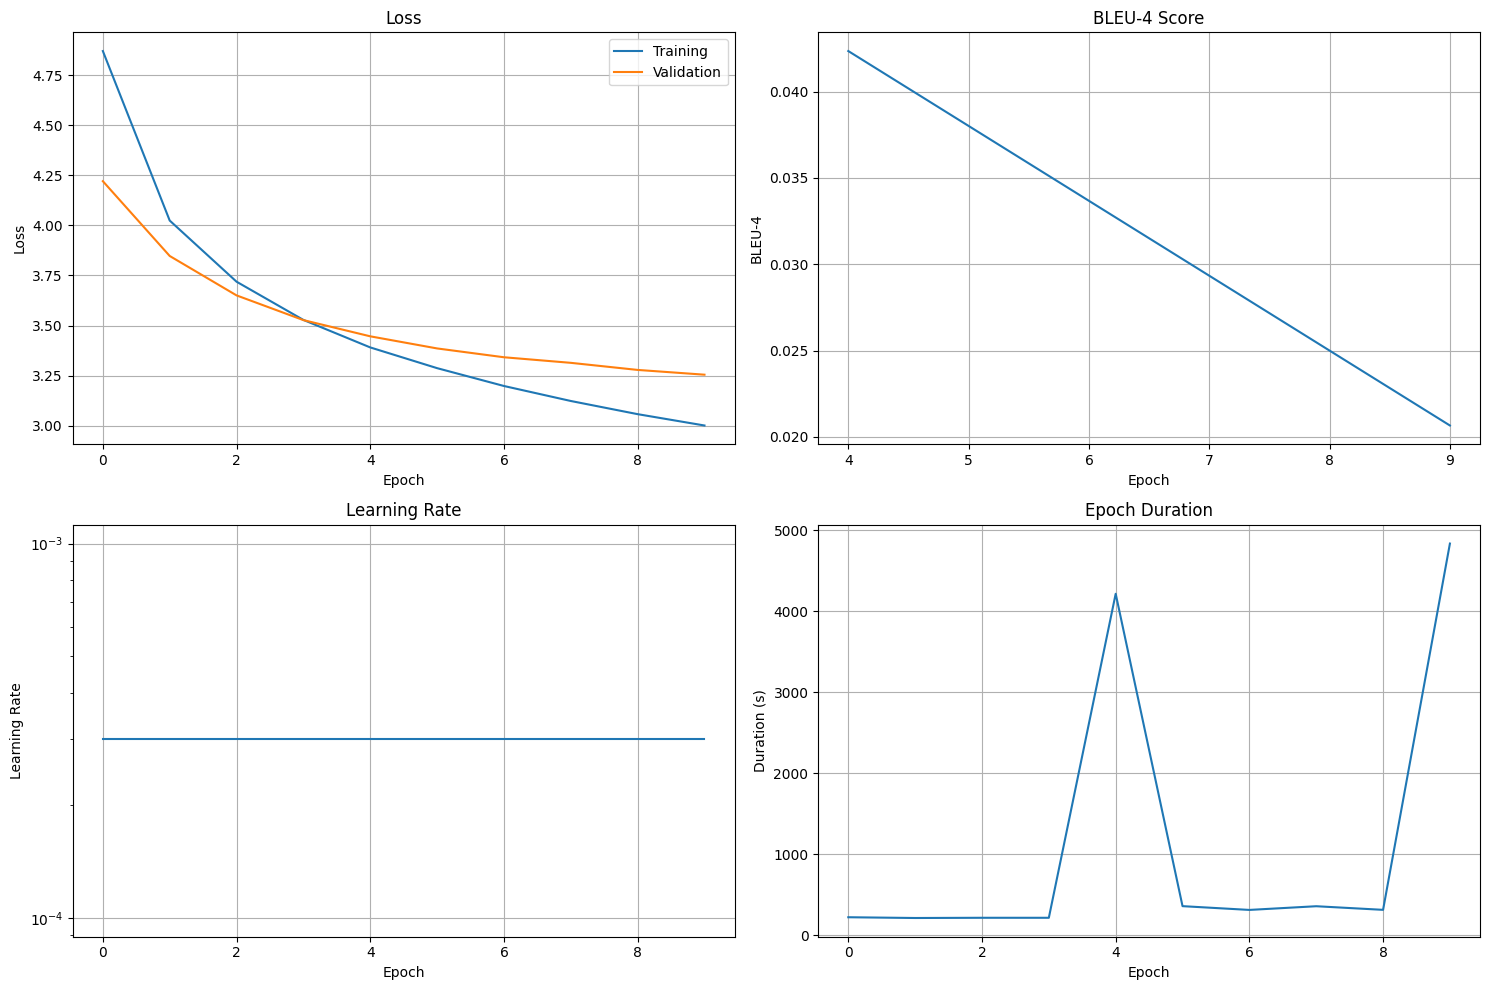

In [ ]:
# Plot training history
fig, axs = trainer.plot_history()
plt.show()

In [ ]:
# Find best epoch
best_epoch = np.argmin(trainer.history['val_loss'])
print(f"Best epoch: {best_epoch + 1}")
print(f"Best validation loss: {trainer.history['val_loss'][best_epoch]:.4f}")

# If BLEU scores were calculated
bleu_epochs = [i for i, bleu in enumerate(trainer.history['val_bleu']) if bleu > 0]
if bleu_epochs:
    best_bleu_epoch = bleu_epochs[np.argmax([trainer.history['val_bleu'][i] for i in bleu_epochs])]
    print(f"Best BLEU epoch: {best_bleu_epoch + 1}")
    print(f"Best BLEU score: {trainer.history['val_bleu'][best_bleu_epoch]:.4f}")

Best epoch: 10
Best validation loss: 3.2542
Best BLEU epoch: 5
Best BLEU score: 0.0424


## 6. Generate Sample Captions

In [ ]:
# Load the best model
best_model_path = os.path.join(config['save_dir'], 'best_model_loss.pth')
trainer.load_checkpoint(best_model_path)
model = trainer.model.to(config['device'])

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL vocabulary.Vocabulary was not an allowed global by default. Please use `torch.serialization.add_safe_globals([Vocabulary])` or the `torch.serialization.safe_globals([Vocabulary])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
model = trainer.model

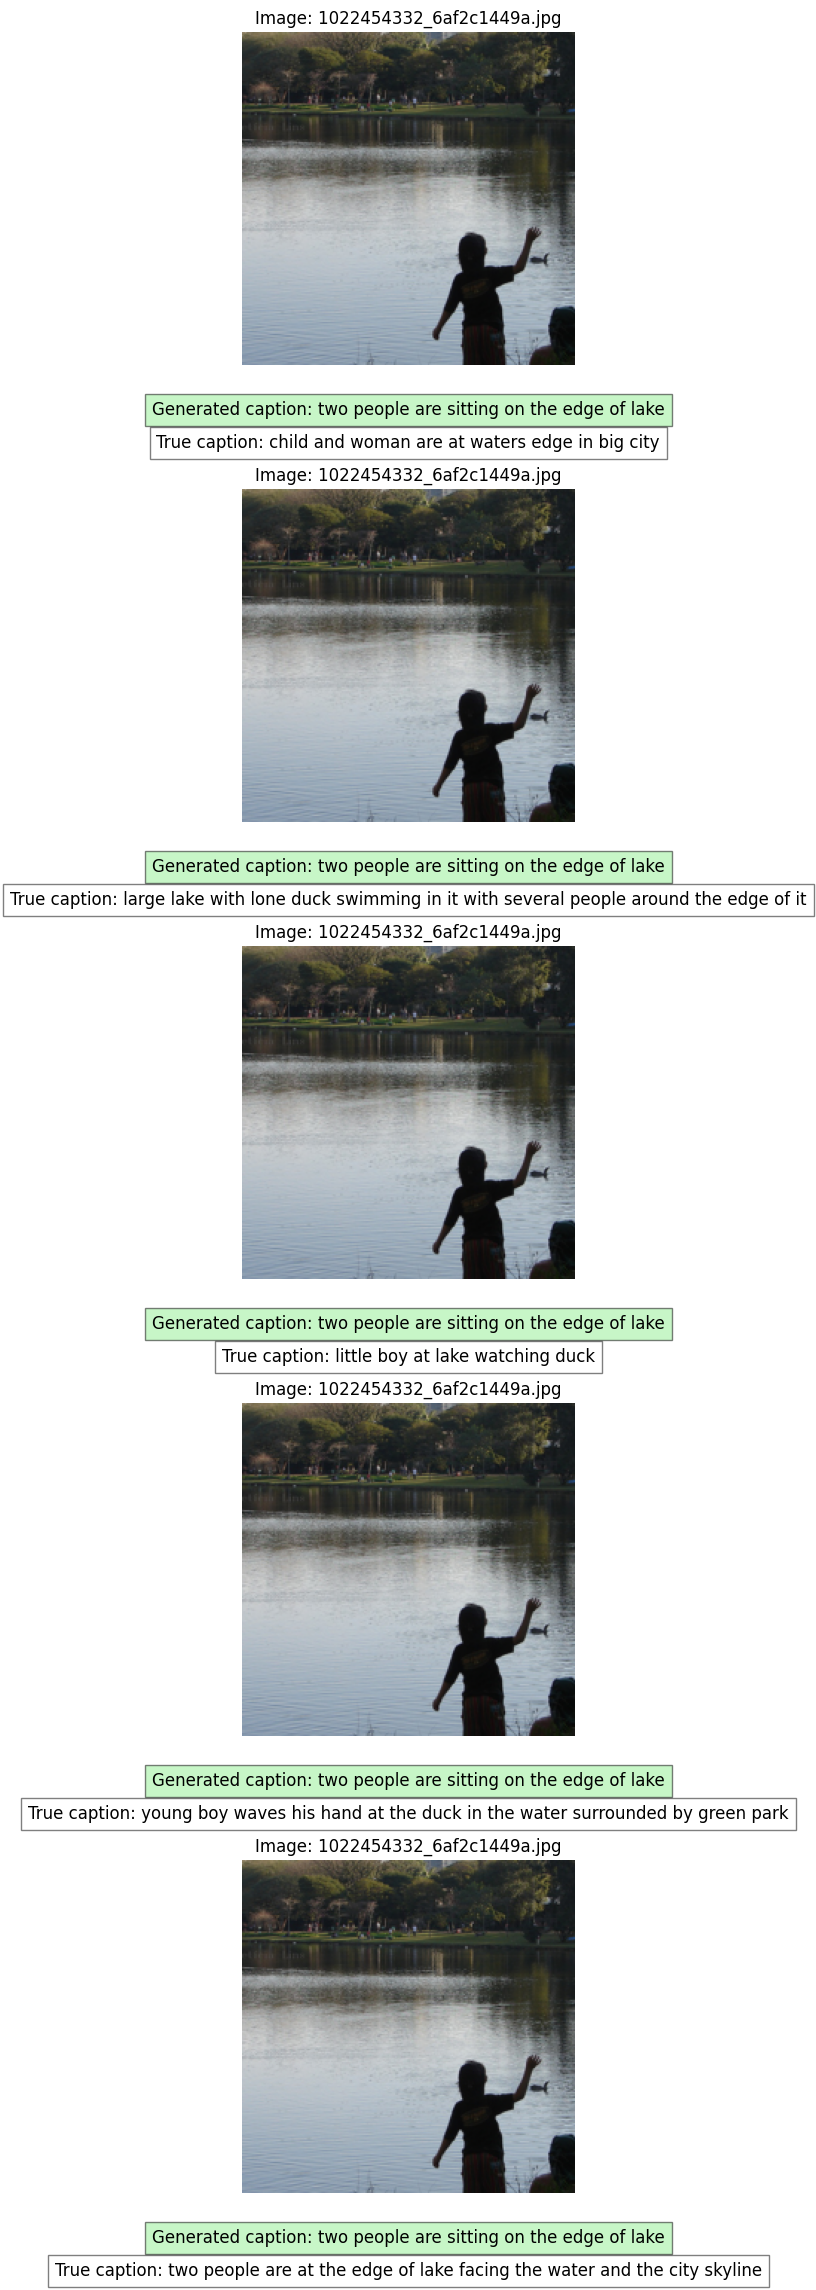

In [ ]:
# Generate captions for some validation images
def generate_caption(image, model: nn.Module, vocab, device):
    """Generate a caption for an image."""

    caption_text = ...
    # TODO: Implement the caption generation function
    # 1. Set the model to evaluation mode
    model.eval()
    # 2. Use torch.no_grad() to disable gradient calculation during inference
    with torch.no_grad():
    # 3. Move the image to the device and add a batch dimension if needed
      image = image.unsqueeze(0)
      image = image.to(device)
    # 4. Generate a caption using the model's generate_caption method
      caption = model.generate_caption(image, max_length= 200, beam_size=1)
    # 5. Decode the caption indices to text using the vocabulary
      caption_text = vocab.decode(caption)
    # 6. Return the caption text
    return caption_text

# Get some validation examples
num_examples = 5
val_examples = []

for images, captions, image_ids in val_loader:
    if len(val_examples) >= num_examples:
        break

    # Generate captions
    for i in range(len(images)):
        if len(val_examples) >= num_examples:
            break

        image = images[i]
        true_caption = vocab.decode(captions[i], join=True, remove_special=True)
        generated_caption = generate_caption(image, model, vocab, config['device'])

        val_examples.append({
            'image': image,
            'image_id': image_ids[i],
            'true_caption': true_caption,
            'generated_caption': generated_caption
        })

# Display examples
plt.figure(figsize=(15, 5 * num_examples))

for i, example in enumerate(val_examples):
    ax = plt.subplot(num_examples, 1, i + 1)

    # Convert tensor to image
    img = example['image'].permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Image: {example['image_id']}")

    # Add captions below image using ax.text
    ax.text(0.5, -0.15, f"Generated caption: {example['generated_caption']}",
            ha='center', fontsize=12, transform=ax.transAxes,
            bbox={"facecolor": "lightgreen", "alpha": 0.5, "pad": 5})

    ax.text(0.5, -0.25, f"True caption: {example['true_caption']}",
            ha='center', fontsize=12, transform=ax.transAxes,
            bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 7. Compare Greedy and Beam Search Decoding

<Figure size 1000x1000 with 0 Axes>

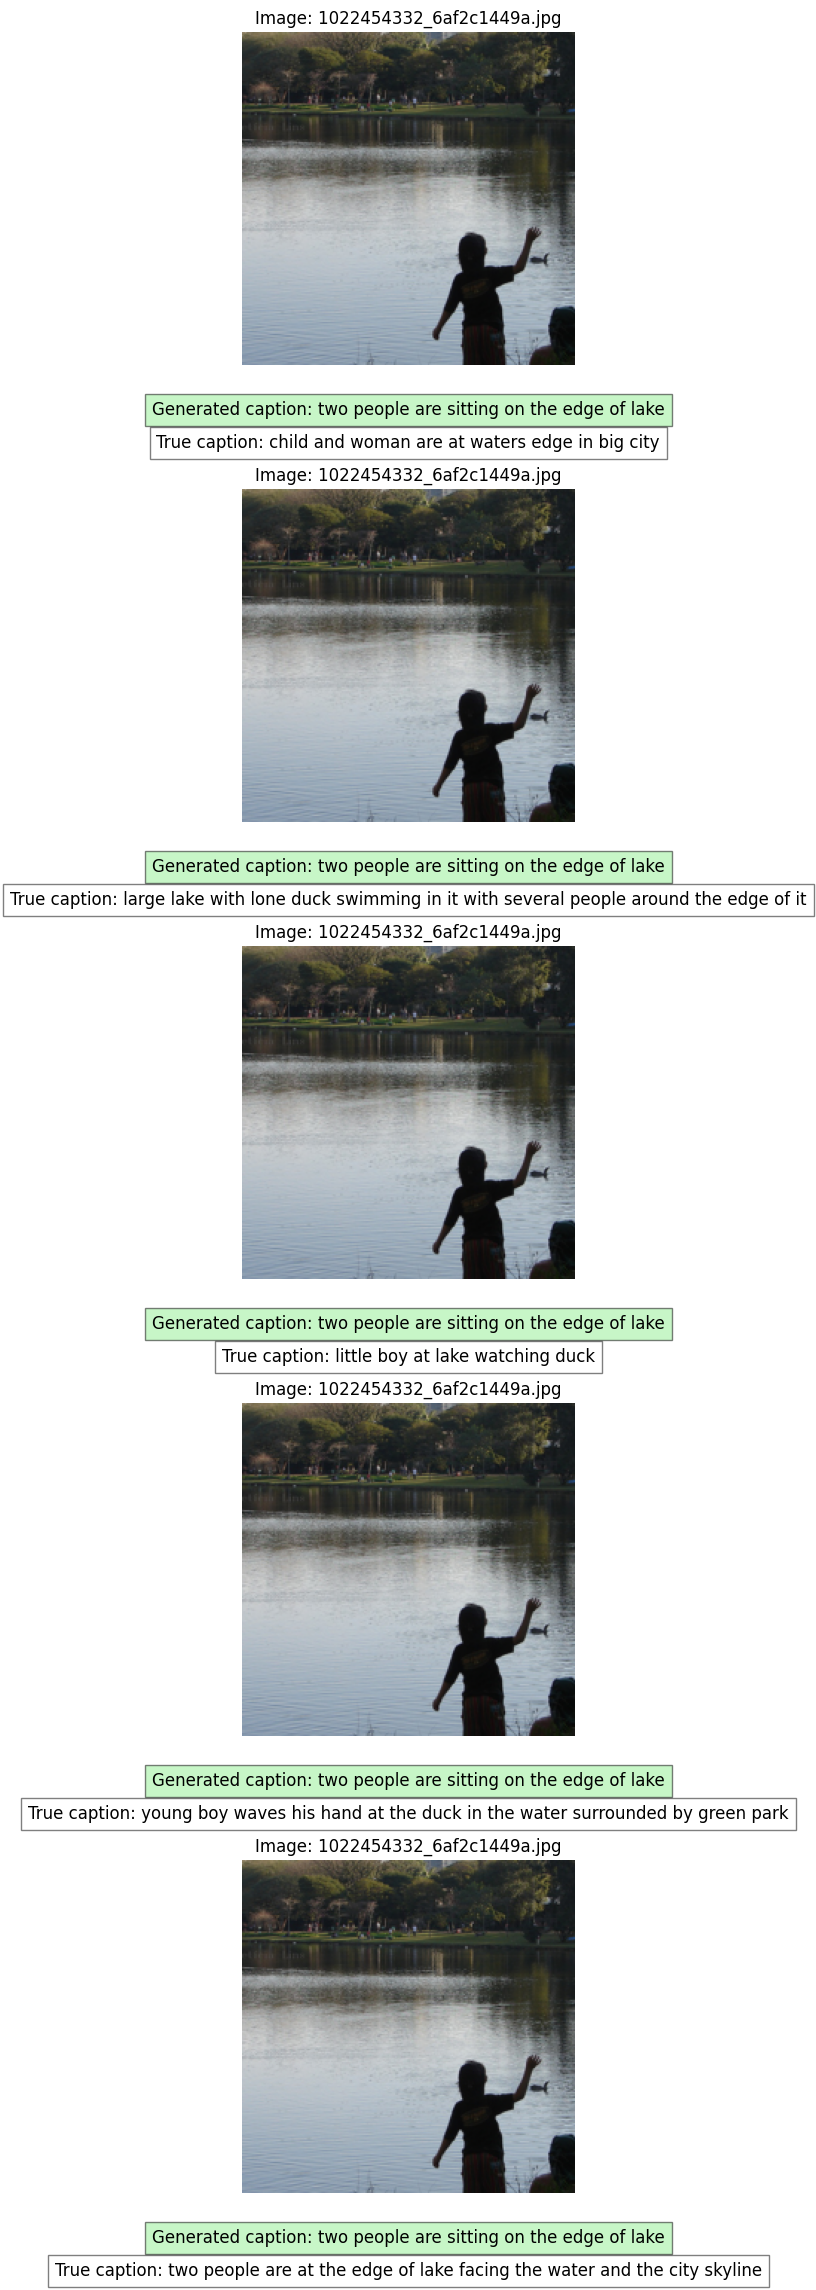

In [ ]:
# Compare greedy decoding vs. beam search
def compare_decoding_methods(image, model, vocab, device, beam_sizes=[1, 3, 5]):
    """Compare different beam search sizes for caption generation."""
    results = ...
    # TODO: Implement a function to compare different beam search settings
    # 1. Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
    # 2. Initialize a dictionary to store results
      results = dict()
    # 3. For each beam size:
      image.unsqueeze(0)
      image = image.to(device)
      for beam_size in beam_sizes:
    #    a. Generate a caption using that beam size
        sampled_ids = model.generate_caption(
                image=image,
                beam_size=beam_size
            )
    #    b. Decode the caption indices to text
        decoded = vocab.decode(sampled_ids, join=True, remove_special=True)
    #    c. Store the result in the dictionary
        label = f'beam_{beam_size}'
        results[label] = decoded

    # 4. Return the dictionary of results

    return results

# Select a random example from val_examples
import random
example = random.choice(val_examples)

# Compare decoding methods
beam_results = compare_decoding_methods(
    example['image'],
    model,
    vocab,
    config['device'],
    beam_sizes=[1, 3, 5]
)

# Display the image with different captions
plt.figure(figsize=(10, 10))

# Display image
img = example['image'].permute(1, 2, 0).numpy()
img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {example['image_id']}")

# Add captions
captions = [
    f"True caption: {example['true_caption']}",
    f"Greedy search: {beam_results['beam_1']}",
    f"Beam search (k=3): {beam_results['beam_3']}",
    f"Beam search (k=5): {beam_results['beam_5']}"
]

# Display captions below the image
plt.figtext(0.5, 0.01, '\n'.join(captions), ha='center', fontsize=12,
            bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout(rect=[0, 0.2, 1, 0.95])
plt.show()

## 8. Save Final Model and Configuration

In [ ]:
# Save configuration
import json
config_path = os.path.join(config['save_dir'], 'config.json')

# Convert non-serializable values to strings
serializable_config = {k: str(v) if not isinstance(v, (int, float, str, bool)) else v
                      for k, v in config.items()}

with open(config_path, 'w') as f:
    json.dump(serializable_config, f, indent=4)

print(f"Configuration saved to {config_path}")

Configuration saved to ../models/config.json


In [ ]:
# Save vocabulary separately for easy access
import pickle
vocab_path = os.path.join(config['save_dir'], 'vocabulary.pkl')
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

print(f"Vocabulary saved to {vocab_path}")

Vocabulary saved to ../models/vocabulary.pkl


In [ ]:
!cp -r ../models /content/drive/MyDrive/"Deep Learning 4032"/HW03/Image-Captioning/Checkpoints

## Summary

In this notebook, we have successfully:

1. Set up the data loaders for training and validation
2. Built the caption model by combining the encoder and decoder
3. Trained the model with teacher forcing
4. Monitored the training progress and validation performance
5. Generated captions for sample images
6. Compared different decoding strategies (greedy vs. beam search)
7. Saved the model, configuration, and vocabulary for later use

In the next notebook, we will perform a comprehensive evaluation of the model on the test set.